# IMPORTS

In [1]:
from utils import *
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import matplotlib.pyplot as plt


## 1- Read Dataset

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns


## Uncomment to read the dataset online

In [3]:

#!pip install ucimlrepo
# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# phiusiil_phishing_url_website = fetch_ucirepo(id=967) 
  
# # data (as pandas dataframes) 
# X = phiusiil_phishing_url_website.data.features 
# y = phiusiil_phishing_url_website.data.targets 
  
# # metadata 
# print(phiusiil_phishing_url_website.metadata) 
  
# # variable information 
# print(phiusiil_phishing_url_website.variables) 


## 2- Preprocessing & Visualization

In [4]:
# load the dataset
DATASET_PATH = "./dataset/PhiUSIIL_Phishing_URL_Dataset.csv"


In [5]:
# find spark
spark = SparkSession.builder.appName("PhishingURL").getOrCreate()
sc = spark.sparkContext


In [6]:
# read dataset
phishing_rdd = spark.read.csv(DATASET_PATH, header=True, inferSchema=True)

In [7]:
# show rdd header and first 10 rows
phishing_rdd.show(10)

+----------+--------------------+---------+--------------------+------------+----------+---+------------------+--------------------+-----------------+-----------+---------+-------------+--------------+------------------+----------------+----------------+----------------+---------------+---------------+---------------+--------------+------------------+--------------------------+---------------------+-------+----------+-----------------+--------+--------------------+---------------------+------------------+----------+------+------------+---------------+----------------+--------------+---------+----------+---------------------+------------+---------------+---------------+----------------+----+---+------+----------------+---------+-------+------+-----------+------------+---------------+-----+
|  FILENAME|                 URL|URLLength|              Domain|DomainLength|IsDomainIP|TLD|URLSimilarityIndex|CharContinuationRate|TLDLegitimateProb|URLCharProb|TLDLength|NoOfSubDomain|HasObfuscation

In [8]:
# drop filename column since it's not relevant
phishing_rdd = phishing_rdd.drop("filename")


In [9]:
# show rows, columns, and schema
print("Rows: ", phishing_rdd.count())
print("Columns: ", len(phishing_rdd.columns))
print("Schema: ", phishing_rdd.printSchema())

Rows:  235795
Columns:  55
root
 |-- URL: string (nullable = true)
 |-- URLLength: integer (nullable = true)
 |-- Domain: string (nullable = true)
 |-- DomainLength: integer (nullable = true)
 |-- IsDomainIP: integer (nullable = true)
 |-- TLD: string (nullable = true)
 |-- URLSimilarityIndex: double (nullable = true)
 |-- CharContinuationRate: double (nullable = true)
 |-- TLDLegitimateProb: double (nullable = true)
 |-- URLCharProb: double (nullable = true)
 |-- TLDLength: integer (nullable = true)
 |-- NoOfSubDomain: integer (nullable = true)
 |-- HasObfuscation: integer (nullable = true)
 |-- NoOfObfuscatedChar: integer (nullable = true)
 |-- ObfuscationRatio: double (nullable = true)
 |-- NoOfLettersInURL: integer (nullable = true)
 |-- LetterRatioInURL: double (nullable = true)
 |-- NoOfDegitsInURL: integer (nullable = true)
 |-- DegitRatioInURL: double (nullable = true)
 |-- NoOfEqualsInURL: integer (nullable = true)
 |-- NoOfQMarkInURL: integer (nullable = true)
 |-- NoOfAmpers

In [10]:
# check the number of missing values in each column
print("Missing values: ")
for col in phishing_rdd.columns:
    print(col, ":", phishing_rdd.where(phishing_rdd[col].isNull()).count())
    

Missing values: 
URL : 0
URLLength : 0
Domain : 0
DomainLength : 0
IsDomainIP : 0
TLD : 0
URLSimilarityIndex : 0
CharContinuationRate : 0
TLDLegitimateProb : 0
URLCharProb : 0
TLDLength : 0
NoOfSubDomain : 0
HasObfuscation : 0
NoOfObfuscatedChar : 0
ObfuscationRatio : 0
NoOfLettersInURL : 0
LetterRatioInURL : 0
NoOfDegitsInURL : 0
DegitRatioInURL : 0
NoOfEqualsInURL : 0
NoOfQMarkInURL : 0
NoOfAmpersandInURL : 0
NoOfOtherSpecialCharsInURL : 0
SpacialCharRatioInURL : 0
IsHTTPS : 0
LineOfCode : 0
LargestLineLength : 0
HasTitle : 0
Title : 0
DomainTitleMatchScore : 0
URLTitleMatchScore : 0
HasFavicon : 0
Robots : 0
IsResponsive : 0
NoOfURLRedirect : 0
NoOfSelfRedirect : 0
HasDescription : 0
NoOfPopup : 0
NoOfiFrame : 0
HasExternalFormSubmit : 0
HasSocialNet : 0
HasSubmitButton : 0
HasHiddenFields : 0
HasPasswordField : 0
Bank : 0
Pay : 0
Crypto : 0
HasCopyrightInfo : 0
NoOfImage : 0
NoOfCSS : 0
NoOfJS : 0
NoOfSelfRef : 0
NoOfEmptyRef : 0
NoOfExternalRef : 0
label : 0


In [11]:
# keep thee unique values of the url column
unique_urls = phishing_rdd.select("url").distinct()
print("Unique URLs: ", unique_urls.count())
filtered_rdd = phishing_rdd.dropDuplicates(["url"])

Unique URLs:  235370


# generate descriptive statistics
filtered_rdd.describe().show()


In [18]:
# split the dataset into the rows that are real and phishing based on the label column
# where 1 is real and 0 is phishing
all_legitimate_rdd = filtered_rdd.where(filtered_rdd["label"] == 1)
all_phishing_rdd = filtered_rdd.where(filtered_rdd["label"] == 0)

In [19]:
# show the number of the legitimate and phishing URLs
print("Legitimate URLs: ", all_legitimate_rdd.count())
print("Phishing URLs: ", all_phishing_rdd.count())


Legitimate URLs:  134850
Phishing URLs:  100520


In [16]:
# The URL similarity index is calculated between a source URL and 
# a target URL. 
# The source URL is the given URL for calculating USI. 
# The target URL is a URL from the list of the top 10 million legitimate 
# websites downloaded from Open PageRank Initiative. 
# Our idea is to find 
# how closely a URL from the list matches any of the URLs from the top 
# 10 million list. 
# A USI 100 shows a legitimate URL, and a USI close to 
# 100 may indicate a phishing URL that looks very similar to a legitimate 
# URL. 
# Each character of the source and target URL is compared; for each 
# matching character, one similarity value is calculated and assigned to 
# it. 
# For all unmatched characters, the ith character from the longest URL 
# is deleted, and the value of i is reduced by 1 to compare the same ith
#  position again in the next iteration.
#  The maximum USI is considered 100, and the minimum is 0. 

Columns after dropping all zeros columns:  55


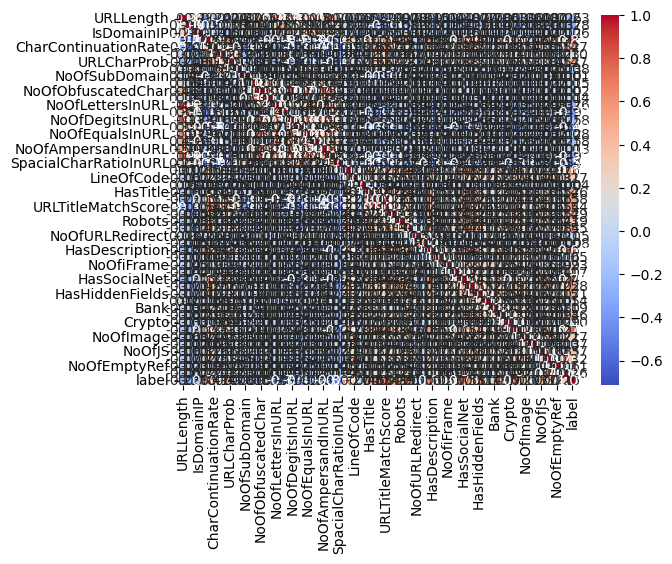

In [15]:
# plot correlation matrix 
# plt.figure(figsize=(10,10))
sns.heatmap(filtered_rdd.toPandas().corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [24]:
# show columns data types
print("Data types: ")
for col in filtered_rdd.columns:
    print(col, ":", filtered_rdd.select(col).dtypes[0][1])

Data types: 
URL : string
URLLength : int
Domain : string
DomainLength : int
IsDomainIP : int
TLD : string
URLSimilarityIndex : double
CharContinuationRate : double
TLDLegitimateProb : double
URLCharProb : double
TLDLength : int
NoOfSubDomain : int
HasObfuscation : int
NoOfObfuscatedChar : int
ObfuscationRatio : double
NoOfLettersInURL : int
LetterRatioInURL : double
NoOfDegitsInURL : int
DegitRatioInURL : double
NoOfEqualsInURL : int
NoOfQMarkInURL : int
NoOfAmpersandInURL : int
NoOfOtherSpecialCharsInURL : int
SpacialCharRatioInURL : double
IsHTTPS : int
LineOfCode : int
LargestLineLength : int
HasTitle : int
Title : string
DomainTitleMatchScore : double
URLTitleMatchScore : double
HasFavicon : int
Robots : int
IsResponsive : int
NoOfURLRedirect : int
NoOfSelfRedirect : int
HasDescription : int
NoOfPopup : int
NoOfiFrame : int
HasExternalFormSubmit : int
HasSocialNet : int
HasSubmitButton : int
HasHiddenFields : int
HasPasswordField : int
Bank : int
Pay : int
Crypto : int
HasCopyrigh

In [27]:
# plot histograms of all numeric columns for legitimate and phishing URLs on the same plot for each column

# Set up the figure size
plt.figure(figsize=(18, 36))
index = 0
for col in filtered_rdd.columns:
    if index >= 10:
        break
    if filtered_rdd.select(col).dtypes[0][1] in ["int", "double"]:
        plt.subplot(8, 3, filtered_rdd.columns.index(col) + 1)
        sns.histplot(all_legitimate_rdd.select(col).toPandas(), color="blue", label="Legitimate", kde=True)
        sns.histplot(all_phishing_rdd.select(col).toPandas(), color="red", label="Phishing", kde=True)
        plt.title(col)
        plt.legend()
        index += 1

Error in callback <function flush_figures at 0x000001FFAE13D670> (for post_execute):


KeyboardInterrupt: 

## 3- Model & Training

## 4- Evaluation